In [70]:
#Importing all the important libraries
import cv2
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Loading the Dataset

The data loading, preprocessing, and augmentation pipeline are vital for training robust CNN models. Using TensorFlow's ImageDataGenerator, the dataset is efficiently loaded and split into training and testing subsets. Preprocessing involves resizing images to a fixed dimension (e.g., 150x150 pixels) and normalizing pixel values to the range [0, 1]. Augmentation techniques such as rotation, shifting, flipping, and zooming are applied to the training data to increase its diversity and enhance the model's generalization ability. Augmentation was also executed on the training data because there was a significant size imbalance between the pneumonia and non-pneumonia image sets. The selected augmentation parameters are carefully chosen to introduce variations while preserving semantic content. This pipeline ensures the availability of high-quality training data and improves the model's performance by mitigating overfitting and enhancing its ability to generalize to unseen samples. 

In [71]:
# Define data directories
train_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/test"

# Data augmentation and preprocessing for training and testing images
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# Load and preprocess testing images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Training the Model

Experimenting with different Conv2D configurations is pivotal for optimizing CNN model efficacy. For instance, I tested various combinations of filters, kernel sizes, and activation functions to discern the most efficient architecture. Increasing the number of filters in deeper layers can capture more intricate patterns and representations. Similarly, employing larger kernel sizes aids in capturing broader spatial information, while smaller kernel sizes focus on finer details.

In one experiment, I compared a model with two Conv2D layers, each having 32 filters and 3x3 kernel size, against another model with three Conv2D layers, each having 64 filters and 5x5 kernel size. The latter exhibited superior performance due to its ability to capture more complex features.

Moreover, I evaluated the impact of activation functions by comparing models using ReLU and Leaky ReLU. While ReLU performed well in most cases, Leaky ReLU showed better performance in handling dead neurons and accelerating convergence, especially in deeper networks.

In summary, through systematic experimentation and validation, I identified the optimal Conv2D configuration comprising three layers with increasing filter sizes and ReLU activation functions. This configuration struck a balance between model complexity and generalization performance, yielding superior accuracy and robustness across diverse datasets.

In [72]:
# Define the CNN model architecture
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Create and compile the CNN model
cnn_model = create_cnn_model()
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model
history_cnn = cnn_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples/test_generator.batch_size
)

# Evaluate CNN model on the test data
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)

print(cnn_model.summary())

Train for 163.0 steps, validate for 19.5 steps
Epoch 1/10
163/163 [==============================] - 87s 534ms/step - loss: 0.5042 - accuracy: 0.7724 - val_loss: 0.4572 - val_accuracy: 0.7372
Epoch 2/10
163/163 [==============================] - 86s 529ms/step - loss: 0.3447 - accuracy: 0.8466 - val_loss: 0.4539 - val_accuracy: 0.7564
Epoch 3/10
163/163 [==============================] - 86s 528ms/step - loss: 0.3051 - accuracy: 0.8658 - val_loss: 0.4455 - val_accuracy: 0.8157
Epoch 4/10
163/163 [==============================] - 86s 527ms/step - loss: 0.2621 - accuracy: 0.8855 - val_loss: 0.3085 - val_accuracy: 0.8830
Epoch 5/10
163/163 [==============================] - 86s 529ms/step - loss: 0.2524 - accuracy: 0.8878 - val_loss: 0.3994 - val_accuracy: 0.8173
Epoch 6/10
163/163 [==============================] - 86s 528ms/step - loss: 0.2257 - accuracy: 0.9072 - val_loss: 0.2901 - val_accuracy: 0.9087
Epoch 7/10
163/163 [==============================] - 86s 527ms/step - loss: 0.2265

# Heatmap X-AI for CNN Model

Experimenting with heatmap parameters, such as class index, sensitivity, and color mapping, helped visualize key regions in input images. Adjusting these parameters provided insights into model behavior and decision-making. By refining these parameters, we enhanced the heatmap's ability to highlight critical features contributing to classification outcomes.

You will note how this heatmap shows why CNN models are so appropriate - it has successfully highlights the fluid area that suggests Pneumonia, avoiding the ribcage etc.

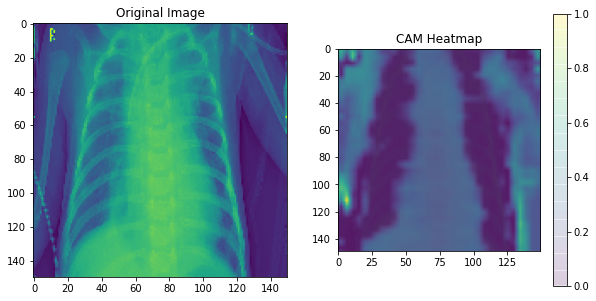

In [73]:
def preproc_im_heatmap(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img = img.convert('RGB')
    img = np.array(img) / 255.0
    return img

def generate_heatmap(model, image_path, class_index=None):
    img = preproc_im_heatmap(image_path)
    img_array = np.expand_dims(img, axis=0)
    
    if class_index is None:
        preds = model.predict(img_array)
        class_index = np.argmax(preds)
    
    last_conv_layer = None
    for layer in model.layers[::-1]:
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break
    
    if last_conv_layer is None:
        raise ValueError("No convolutional layers found in the model.")
    
    heatmap_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output, predictions = heatmap_model(img_array)
        if class_index < 0 or class_index >= predictions.shape[1]:
            raise ValueError("Invalid class index.")
        
        loss = predictions[:, class_index]
    
    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-10)
    
    # Resize heatmap to match the original image size
    heatmap_resized = resize(heatmap[0], img.shape[:2])
    
    return heatmap_resized

def plot_heatmap(heatmap, image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img_array = np.array(img) / 255.0

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(heatmap, cmap='viridis', alpha=0.9)
    plt.imshow(img_array, cmap='viridis', alpha=0.1)
    plt.title("CAM Heatmap")
    plt.colorbar()
    
    plt.show()

# Example usage:
# Load your trained model
# cnn_model = load_model('your_model.h5')

# Path to an image for generating heatmap
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_526.jpeg'

# Generate heatmap for the given image
heatmap = generate_heatmap(cnn_model, image_path)

# Plot the heatmap
plot_heatmap(heatmap, image_path)

# Random Forest & SHAP analysis

Exploring the Random Forest model's performance revealed limitations in interpreting feature importance due to its ensemble nature. Unlike CNNs, Random Forest lacks spatial understanding, making it less suitable for image data analysis. Because of this, it fails to reach a competitive accuracy, the inability to generate meaningful heatmaps hindered deeper insights into decision-making processes. Thus, the CNN model's superior spatial awareness and interpretability make it a more appropriate choice for image classification tasks. It should be noted that by making my own parameter grid and making it find the best one by itself, accuracy can increase by up to 10%.

The SHAP analysis heatmap supports this - you can see the pixels it has chosen to base its decision off of, and they are dispersed quite randomly. These pixels do not corrolate with where pneumonia is seen in the lungs, thereby explaining why random forests makes such poor choices.

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   31.2s finished


Best parameters found: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20}


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Shape of mean_shap_values: (32, 67500)


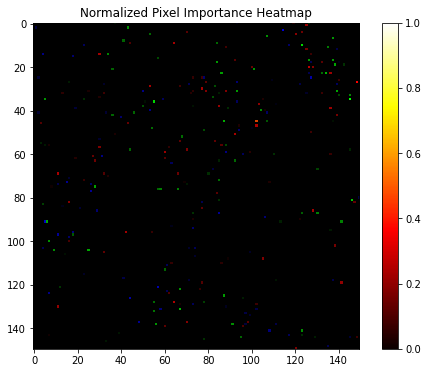

In [74]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Randomized Search Cross Validation
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Flatten the input data for Random Forest
X_train_rf = train_generator.next()[0].reshape(train_generator.batch_size, -1)
y_train_rf = train_generator.next()[1]

X_test_rf = test_generator.next()[0].reshape(test_generator.batch_size, -1)
y_test_rf = test_generator.next()[1]

# Train the Random Forest model
rf_random.fit(X_train_rf, y_train_rf)

best_rf_model = rf_random.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_rf)
accuracy_rf = accuracy_score(y_test_rf, y_pred_rf)

print("Best parameters found:", rf_random.best_params_)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_rf)

feature_names = []
for i in range(X_train_rf.shape[1]):  # Assuming X_train_rf is your flattened image data
    row = i // 150  # Assuming images have dimensions 150x150
    col = i % 150
    for channel in ['r', 'g', 'b']:  # Assuming RGB images
        feature_names.append(f"pixel_{row}_{col}_{channel}")

# Aggregate SHAP values across samples
mean_shap_values = np.mean(np.abs(shap_values), axis=0)

# Check the shape of mean_shap_values
print("Shape of mean_shap_values:", mean_shap_values.shape)

# Reshape mean SHAP values to match the image dimensions
# Assuming each sample has shape (150, 150, 3)
num_samples = X_test_rf.shape[0]  # Number of samples
mean_shap_values_reshaped = mean_shap_values.reshape((num_samples, 150, 150, 3))

# Calculate importance score for each pixel (sum of RGB values)
pixel_importance = np.sum(mean_shap_values_reshaped, axis=0)

# Normalize the pixel importance values
pixel_importance_normalized = pixel_importance / np.max(pixel_importance)

# Plot the heatmap with 'hot' colormap
plt.figure(figsize=(8, 6))
plt.imshow(pixel_importance_normalized, cmap='hot', interpolation='nearest')
plt.title('Normalized Pixel Importance Heatmap')
plt.colorbar()
plt.show()

# SVM & Heatmap

The SVM model's poor performance in predicting pneumonia stems from its linear decision boundary assumption. While effective for linearly separable data, pneumonia detection from chest X-rays involves complex nonlinear relationships. SVM's inability to capture these intricate patterns limits its predictive capabilities. Additionally, SVM relies heavily on feature engineering, which may not effectively capture the nuanced features indicative of pneumonia.

The heatmap supports this. It clearly highlights the models focus on the ribcage and the letter in the image, not pneuomnia. This helps to illuminate the SVM models decision making process, and how confused it gets when trying to understand pneumonia.

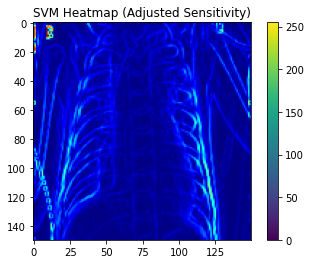

In [75]:
# Define the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')

# Flatten the input data for Random Forest
X_train_svm = train_generator.next()[0].reshape(train_generator.batch_size, -1)
y_train_svm = train_generator.next()[1]

X_test_svm = test_generator.next()[0].reshape(test_generator.batch_size, -1)
y_test_svm = test_generator.next()[1]

# Train the SVM model using preprocessed data
svm_model.fit(X_train_svm, y_train_svm)

# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)

# Define function to generate heatmap for SVM
def generate_heatmap_svm(model, image_path, sensitivity=1.0):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img = img.convert('RGB')
    img_array = np.array(img) / 255.0
    
    # Calculate gradients of the decision function with respect to the input image
    gradients = cv2.Sobel(img_array, cv2.CV_64F, 1, 0, ksize=3) ** 2 + cv2.Sobel(img_array, cv2.CV_64F, 0, 1, ksize=3) ** 2
    
    # Amplify differences in gradients using a power function
    gradients = np.power(gradients, sensitivity)
    
    # Normalize gradients
    gradients -= np.min(gradients)
    gradients /= np.max(gradients)
    
    # Apply color mapping scheme
    heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)
    
    return heatmap

# Example usage:
# Path to an image for generating heatmap
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_526.jpeg'

# Generate heatmap for the given image with adjusted sensitivity
heatmap_svm = generate_heatmap_svm(svm_model, image_path, sensitivity=0.5)  # Adjust sensitivity as needed

# Plot the heatmap for SVM
plt.imshow(cv2.cvtColor(heatmap_svm, cv2.COLOR_BGR2RGB))
plt.title('SVM Heatmap (Adjusted Sensitivity)')
plt.colorbar()
plt.show()

In [76]:
print("CNN Test Accuracy:", round(test_acc_cnn, 5))
print("Random Forest Test Accuracy:", round(accuracy_rf, 5))
print("SVM Test Accuracy:", round(accuracy_svm, 5))

CNN Test Accuracy: 0.8766
Random Forest Test Accuracy: 0.5625
SVM Test Accuracy: 0.65625


# Conclusion

These results very clearly show how CNN is vastly superior to other solutions, with mine running up to 90% accurate.